In [ ]:
!pip install spektral
!pip install tensorflow==2.15.0
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import lil_matrix, csr_matrix
from spektral.data import Graph
from spektral.utils import normalized_adjacency
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from spektral.layers import GATConv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.1/140.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 81.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 6.0 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.0
    Uninstalling wrapt-1.17.0:
      Successfully uninstalled wrapt-1.17.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled

Optimizing parameters: 100%|██████████| 20/20 [2:32:38<00:00, 457.93s/it]


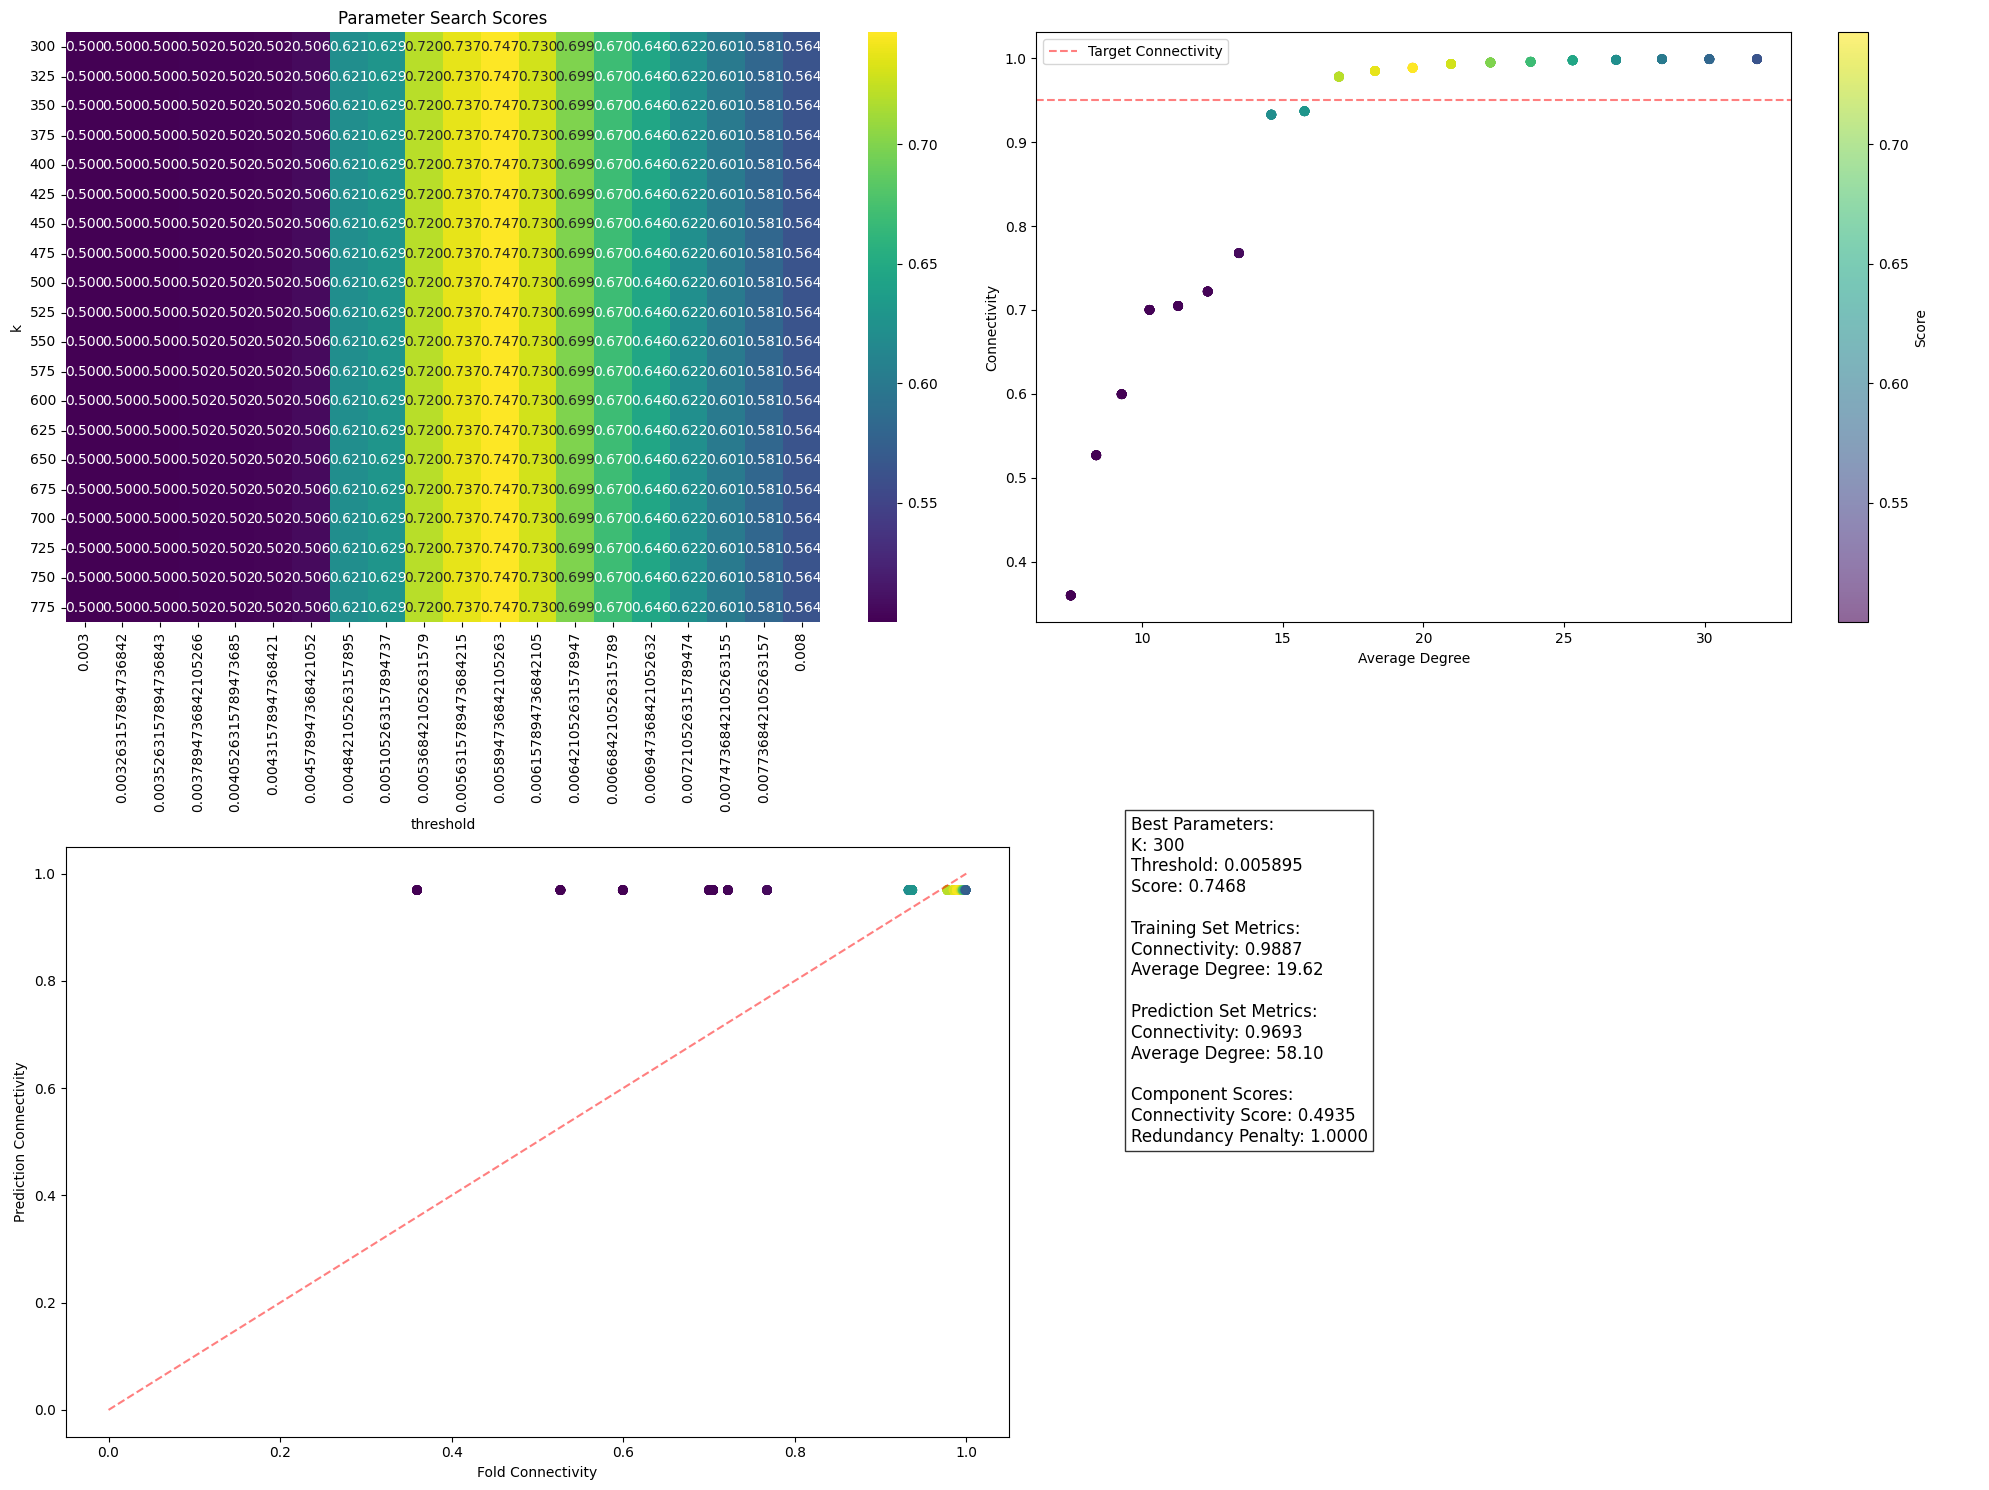

In [ ]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import lil_matrix, csr_matrix
from scipy.sparse.csgraph import connected_components
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

class ConnectivityOptimizer:
    def __init__(self, fold_data, pred_df):
        self.fold_data = fold_data[0]  # 使用第一个fold
        self.pred_df = pred_df

    def analyze_graph_properties(self, df, k, threshold):
        """分析图的属性，重点关注连通性和度数分布"""
        coords = df[['Normalized_X', 'Normalized_Y']].values

        # 构建KNN图
        neigh = NearestNeighbors(n_neighbors=k+1).fit(coords)
        distances, indices = neigh.kneighbors(coords)

        # 构建邻接矩阵
        adjacency = lil_matrix((len(coords), len(coords)), dtype=np.float32)
        edge_count = 0
        degrees = []

        for i in range(len(coords)):
            node_degree = 0
            for j in range(1, k+1):
                if distances[i, j] < threshold:
                    adjacency[i, indices[i, j]] = 1
                    edge_count += 1
                    node_degree += 1
            degrees.append(node_degree)

        adjacency = adjacency.tocsr()
        adjacency.setdiag(0)
        adjacency.eliminate_zeros()

        # 计算连通性
        n_components, labels = connected_components(adjacency, directed=False)
        components_sizes = np.bincount(labels)
        largest_component = components_sizes.max()

        # 计算度数分布
        degrees = np.array(degrees)

        return {
            'connectivity': largest_component / len(coords),
            'avg_degree': edge_count / len(coords),
            'n_components': n_components,
            'degree_std': np.std(degrees),
            'isolated_nodes': np.sum(degrees == 0),
            'max_degree': np.max(degrees),
            'degree_distribution': degrees
        }

    def optimize_parameters(self):
        """优化参数，重点关注训练集连通性"""
        # 调整搜索范围，关注较高的K值
        k_values = np.arange(300, 800, 25)
        threshold_values = np.linspace(0.003, 0.008, 20)

        results = []
        best_score = -1
        best_params = None

        for k in tqdm(k_values, desc="Optimizing parameters"):
            for threshold in threshold_values:
                # 分析训练集和预测集属性
                fold_props = self.analyze_graph_properties(self.fold_data, k, threshold)
                pred_props = self.analyze_graph_properties(self.pred_df, k, threshold)

                # 计算训练集连通性得分
                # 使用sigmoid函数使得连通性在0.95附近有最佳得分
                connectivity_score = 1 / (1 + np.exp(-20 * (fold_props['connectivity'] - 0.99)))

                # 计算过度连接惩罚
                redundancy_penalty = np.exp(-0.1 * (fold_props['avg_degree'] - 20))
                if fold_props['avg_degree'] < 20:
                    redundancy_penalty = 1.0

                # 计算预测集连通性的基础要求
                pred_connectivity_requirement = 1 if pred_props['connectivity'] > 0.9 else 0.5

                # 最终得分
                score = (
                    0.5 * connectivity_score +
                    0.3 * redundancy_penalty +
                    0.2 * pred_connectivity_requirement
                )

                results.append({
                    'k': k,
                    'threshold': threshold,
                    'score': score,
                    'fold_connectivity': fold_props['connectivity'],
                    'fold_avg_degree': fold_props['avg_degree'],
                    'pred_connectivity': pred_props['connectivity'],
                    'pred_avg_degree': pred_props['avg_degree'],
                    'connectivity_score': connectivity_score,
                    'redundancy_penalty': redundancy_penalty
                })

                if score > best_score:
                    best_score = score
                    best_params = results[-1].copy()

        self.results = pd.DataFrame(results)
        return best_params, self.results

    def visualize_results(self):
        """可视化优化结果"""
        plt.figure(figsize=(20, 15))

        # 1. 参数搜索热力图
        plt.subplot(221)
        pivot = self.results.pivot(
            index='k',
            columns='threshold',
            values='score'
        )
        sns.heatmap(pivot, annot=True, fmt='.3f', cmap='viridis')
        plt.title('Parameter Search Scores')

        # 2. 训练集连通性vs平均度数
        plt.subplot(222)
        plt.scatter(
            self.results['fold_avg_degree'],
            self.results['fold_connectivity'],
            c=self.results['score'],
            cmap='viridis',
            alpha=0.6
        )
        plt.axhline(y=0.95, color='r', linestyle='--', alpha=0.5, label='Target Connectivity')
        plt.xlabel('Average Degree')
        plt.ylabel('Connectivity')
        plt.colorbar(label='Score')
        plt.legend()

        # 3. 连通性比较
        plt.subplot(223)
        plt.scatter(
            self.results['fold_connectivity'],
            self.results['pred_connectivity'],
            c=self.results['score'],
            cmap='viridis',
            alpha=0.6
        )
        plt.plot([0, 1], [0, 1], 'r--', alpha=0.5)
        plt.xlabel('Fold Connectivity')
        plt.ylabel('Prediction Connectivity')

        # 4. 最佳参数信息
        plt.subplot(224)
        best_params = self.results.loc[self.results['score'].idxmax()]
        info_text = (
            f"Best Parameters:\n"
            f"K: {int(best_params['k'])}\n"
            f"Threshold: {best_params['threshold']:.6f}\n"
            f"Score: {best_params['score']:.4f}\n\n"
            f"Training Set Metrics:\n"
            f"Connectivity: {best_params['fold_connectivity']:.4f}\n"
            f"Average Degree: {best_params['fold_avg_degree']:.2f}\n\n"
            f"Prediction Set Metrics:\n"
            f"Connectivity: {best_params['pred_connectivity']:.4f}\n"
            f"Average Degree: {best_params['pred_avg_degree']:.2f}\n\n"
            f"Component Scores:\n"
            f"Connectivity Score: {best_params['connectivity_score']:.4f}\n"
            f"Redundancy Penalty: {best_params['redundancy_penalty']:.4f}"
        )
        plt.text(0.1, 0.5, info_text, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
        plt.axis('off')

        plt.tight_layout()
        plt.show()

def optimize_connectivity_parameters(fold_data, pred_df):
    """主函数：优化图参数，重点关注连通性"""
    optimizer = ConnectivityOptimizer(fold_data, pred_df)
    best_params, results = optimizer.optimize_parameters()
    optimizer.visualize_results()
    return best_params, results


# 读取数据
# fold_data = []
# for i in range(5):
#     fold_df = pd.read_csv(f'/content/drive/MyDrive/dataset/GNN_fold_{i+1}.csv')
#     fold_data.append(fold_df)

# pred_df = pd.read_csv('/content/drive/MyDrive/dataset/GNN_pred_genset_norm.csv')

# 运行优化
best_params, results = optimize_connectivity_parameters(fold_data, pred_df)

nomorlize

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.neighbors import NearestNeighbors
from scipy.sparse import lil_matrix

# # Spektral 1.x 核心接口
# from spektral.data import Graph, Dataset
# from spektral.data.loaders import DisjointLoader
# from spektral.layers import GraphSageConv
# from spektral.utils import normalized_adjacency

from tensorflow.keras import Model
from tensorflow.keras.layers import BatchNormalization, Dropout, Dense, GaussianNoise
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

def check_and_clean_df(df):
    """
    替换正无穷/负无穷为 NaN，并清理所有行中出现 NaN 的记录；
    如果你不想直接删掉对应行，也可以改成填充策略。
    """
    # 将正无穷、负无穷替换为 NaN
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    # 统计 NaN 数量
    nan_count = df.isna().sum().sum()
    if nan_count > 0:
        print(f"Warning: found {nan_count} NaNs, dropping these rows...")
        df.dropna(axis=0, how='any', inplace=True)

    return df


# 1️⃣ =============== 读入 CSV 数据（并转为 float32） ===============
train_df = pd.read_csv('/content/drive/MyDrive/dataset/normalized/normalized_train3.csv')
val_df   = pd.read_csv('/content/drive/MyDrive/dataset/normalized/normalized_validation3.csv')
test_df  = pd.read_csv('/content/drive/MyDrive/dataset/normalized/normalized_test3.csv')
# train_df = pd.read_csv('/content/drive/MyDrive/dataset/GNN_train3.csv')
# val_df   = pd.read_csv('/content/drive/MyDrive/dataset/GNN_validation3.csv')
# test_df  = pd.read_csv('/content/drive/MyDrive/dataset/GNN_test3.csv')
# 先检查清理 NaN / Inf
train_df = check_and_clean_df(train_df)
val_df   = check_and_clean_df(val_df)
test_df  = check_and_clean_df(test_df)

model training

In [ ]:
# ===================== 安装依赖（若已安装可跳过） =====================
!pip install spektral==1.3.1 tensorflow==2.15.0 numpy pandas scikit-learn scipy matplotlib

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.neighbors import NearestNeighbors
from scipy.sparse import lil_matrix

# Spektral 1.x
from spektral.data import Graph, Dataset
from spektral.data.loaders import DisjointLoader
from spektral.layers import GraphSageConv
from spektral.utils import normalized_adjacency

from tensorflow.keras import Model
from tensorflow.keras.layers import BatchNormalization, Dropout, Dense, GaussianNoise
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


# 1️⃣ =================== 读入并处理 DataFrame ===================
train_df = pd.read_csv('/content/drive/MyDrive/dataset/normalized/normalized_train3.csv')
val_df   = pd.read_csv('/content/drive/MyDrive/dataset/normalized/normalized_validation3.csv')
test_df  = pd.read_csv('/content/drive/MyDrive/dataset/normalized/normalized_test3.csv')

feature_columns = train_df.columns[1:-4].tolist()  # 去掉第 0 列和后 4 列
label_column = 'Average_Clip_dBA'

min_label = train_df[label_column].min()
max_label = train_df[label_column].max()
print(f"min_label: {min_label}, max_label: {max_label}")


# 2️⃣ =================== 特征加权: buffer_distances ===================
def calculate_weight(distance, reference_distance, alpha):
    return np.exp(-alpha * (distance - reference_distance))

def apply_weights(df, feature_cols, buffer_distances, ref_dist=30, alpha=0.006):
    weights = {f'r{int(dist)}': calculate_weight(dist, ref_dist, alpha)
               for dist in buffer_distances}
    for col in feature_cols:
        for r, w in weights.items():
            if f'_{r}_' in col:
                df[col] *= w
                break
    return df

buffer_distances = [30, 60, 90, 120, 150]
train_df = apply_weights(train_df, feature_columns, buffer_distances)
val_df   = apply_weights(val_df,   feature_columns, buffer_distances)
test_df  = apply_weights(test_df,  feature_columns, buffer_distances)


# 3️⃣ =================== 构建邻接矩阵 & Graph ===================
def build_graph(df, feat_cols, label_col, k=841, threshold=0.04):
    coords = df[['Normalized_X', 'Normalized_Y']].values

    x = df[feat_cols].values.astype(np.float32)
    # 注意这里把 y reshape 成 (N,1)，方便节点级回归
    y = ((df[label_col].values - min_label) / (max_label - min_label)).astype(np.float32)
    y = np.expand_dims(y, axis=-1)  # 形状 (N,) -> (N,1)

    neigh = NearestNeighbors(n_neighbors=k + 1, algorithm='auto').fit(coords)
    distances, indices = neigh.kneighbors(coords)

    adjacency = lil_matrix((coords.shape[0], coords.shape[0]), dtype=np.float32)
    for i in range(coords.shape[0]):
        for j in range(1, k+1):
            if distances[i, j] < threshold:
                adjacency[i, indices[i, j]] = 1.0

    adjacency = adjacency.tocsr()
    adjacency.setdiag(0)
    adjacency.eliminate_zeros()

    # 归一化
    a_norm = normalized_adjacency(adjacency, symmetric=True)

    return Graph(x=x, a=a_norm, y=y)

train_graph = build_graph(train_df, feature_columns, label_column)
val_graph   = build_graph(val_df,   feature_columns, label_column)
test_graph  = build_graph(test_df,  feature_columns, label_column)

del train_df, val_df, test_df


# 4️⃣ =================== 封装成 Dataset ===================
class SingleGraphDataset(Dataset):
    def __init__(self, g: Graph, transforms=None):
        self.g = g
        super().__init__(transforms=transforms)
    def read(self):
        return [self.g]

train_dataset = SingleGraphDataset(train_graph)
val_dataset   = SingleGraphDataset(val_graph)
test_dataset  = SingleGraphDataset(test_graph)


# 5️⃣ =================== 用 DisjointLoader (node_level) + 邻居采样 ===================
# sample_neighbors=[15,15,15,15,15,15] 表示 6 层 GNN，每层最多采 15 个邻居
# 这样能防止一下子拿到整张图 (3万节点) 造成形状问题或 OOM
BATCH_SIZE = 1024

train_loader = DisjointLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    node_level=True,
    shuffle=False   # 先关闭 shuffle，确保稳定
)

val_loader = DisjointLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    node_level=True,
    shuffle=False
)

test_loader = DisjointLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    node_level=True,
    shuffle=False
)

# 如果上面跑通，就可以尝试把 train_loader 改成 shuffle=True 再看效果.


# 6️⃣ =================== 定义模型 (GraphSAGE) ===================
class GraphSageRegressor(Model):
    def __init__(self, n_hidden=384, depth=6, dropout_rate=0.15, noise_stddev=0.07):
        super().__init__()
        self.noise = GaussianNoise(noise_stddev)
        self.convs = [GraphSageConv(n_hidden, activation=None) for _ in range(depth)]
        self.bns   = [BatchNormalization() for _ in range(depth)]
        self.drop  = Dropout(dropout_rate)

        self.dense1 = Dense(512, activation='elu')
        self.drop2  = Dropout(0.15)
        self.out    = Dense(1, activation='linear')  # 回归 => shape (N,1)

    def call(self, inputs):
        x, a, i = inputs  # i是节点索引（单图里用不到）
        x = self.noise(x)

        for conv, bn in zip(self.convs, self.bns):
            x = conv([x, a])
            x = bn(x)
            x = tf.nn.relu(x)
            x = self.drop(x)

        x = self.dense1(x)
        x = self.drop2(x)
        return self.out(x)

model = GraphSageRegressor()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss=tf.keras.losses.Huber(delta=1.6),
    metrics=['mae']
)


# 7️⃣ =================== 训练 & 验证 ===================
epochs = 10  # 先试跑 10 epoch 以观察形状/报错
callbacks = [
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_mae', mode='min'),
    EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_mae', factor=0.8, patience=3, min_lr=1e-8),
]

print("Start training ...")
history = model.fit(
    train_loader.load(),
    steps_per_epoch=train_loader.steps_per_epoch,
    validation_data=val_loader.load(),
    validation_steps=val_loader.steps_per_epoch,
    epochs=epochs,
    callbacks=callbacks,
    # run_eagerly=True,  # 如果想让 TF 显示更详细的 Python stack trace，可启用
)


# 8️⃣ =================== 测试集评估 ===================
print("Evaluating on test set ...")
test_loss, test_mae = model.evaluate(
    test_loader.load(),
    steps=test_loader.steps_per_epoch
)
print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")


# 9️⃣ =================== 画图 ===================
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GraphSAGE with neighbor sampling (mini-batch)')
plt.show()


min_label: 35.3, max_label: 101.0
Start training ...
Epoch 1/10


In [ ]:
import numpy as np

buffer_distances = [30, 60, 90, 120, 150, 300]  # 缓冲区的距离范围
reference_distance = 30  # 参考距离
alpha = 0.006  # 空气吸收系数

# 计算每个缓冲区的权重
weights = {}
for distance in buffer_distances:
    weight = np.exp(-alpha * (distance - reference_distance))
    weights[f'r{int(distance)}'] = weight

# 打印权重
for r, weight in weights.items():
    print(f'{r}: {weight}')

r30: 1.0
r60: 0.835270211411272
r90: 0.697676326071031
r120: 0.5827482523739896
r150: 0.4867522559599717
r300: 0.19789869908361465


Prediction

In [ ]:
# 加载预测数据集
predict_df = pd.read_csv('/content/drive/MyDrive/dataset2/normalized_GNN_predset.csv')

# 标准化预测集
predict_df[feature_columns] = scaler.transform(predict_df[feature_columns])
min_label = train_df['Average_Clip_dBA'].min()  # 使用适当的min_label和max_label
max_label = train_df['Average_Clip_dBA'].max()
del train_df

# 应用与训练一致的权重
buffer_distances = [30, 60, 90, 120, 150, 300]
reference_distance = 30
alpha = 0.01  # 使用与训练时相同的alpha
predict_df = apply_weights(predict_df, feature_columns, buffer_distances, reference_distance, alpha)

# 构建图数据
k = 841
threshold = 0.04
predict_graph = build_graph(predict_df, feature_columns, k, threshold)
del predict_df
# 转换邻接矩阵为稀疏张量
predict_A = convert_to_sparse_tensor(predict_graph.a)
predict_X = predict_graph.x

# 进行预测
predictions = model.predict([predict_X, predict_A])

In [ ]:
!pip install spektral
!pip install tensorflow==2.15.0
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import lil_matrix, csr_matrix
from spektral.data import Graph
from spektral.utils import normalized_adjacency
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from spektral.layers import GATConv


# 加载数据
train_df = pd.read_csv('/content/drive/MyDrive/dataset2/GNN_train.csv')


# 假设feature_columns是除了最后三列和Index、Label以外的所有列名
feature_columns = train_df.columns[1:-5].tolist()

# 使用预测数据集拟合归一化标准
scaler = MinMaxScaler()
# scaler.fit(predict_df[feature_columns])
scaler.fit(train_df[feature_columns])
# del predict_df

#加载后续数据集
val_df = pd.read_csv('/content/drive/MyDrive/dataset2/GNN_validation.csv')
test_df = pd.read_csv('/content/drive/MyDrive/dataset2/GNN_test.csv')

# 标准化训练集、验证集、测试集
train_df[feature_columns] = scaler.transform(train_df[feature_columns])
val_df[feature_columns] = scaler.transform(val_df[feature_columns])
test_df[feature_columns] = scaler.transform(test_df[feature_columns])


def calculate_weight(distance, reference_distance, alpha):
    """
    计算每个缓冲区的权重。

    """
    return np.exp(-alpha * (distance - reference_distance))

def apply_weights(df, feature_columns, buffer_distances, reference_distance=30, alpha=0.005):
    """
    根据指定的距离范围和空气吸收系数计算权重，并将其应用到数据框中的各个统计量列上。

    """
    # 计算每个缓冲区的权重
    weights = {f'r{int(distance)}': calculate_weight(distance, reference_distance, alpha) for distance in buffer_distances}

    # 应用权重到指定的特征列
    for column in feature_columns:
        for r, weight in weights.items():
            if f'_{r}_' in column:
                df[column] *= weight
                break
    return df

buffer_distances = [30, 60, 90, 120, 150]  # 缓冲区的距离范围
reference_distance = 30  # 参考距离
alpha = 0.006  # 空气吸收系数

# 应用权重
train_df = apply_weights(train_df, feature_columns, buffer_distances, reference_distance, alpha)
val_df = apply_weights(val_df, feature_columns, buffer_distances, reference_distance, alpha)
test_df = apply_weights(test_df, feature_columns, buffer_distances, reference_distance, alpha)

label_column = 'Average_Clip_dBA'
threshold = 0.04
k = 841
min_label = train_df[label_column].min()
print('min_label: '+ str(min_label))
max_label = train_df[label_column].max()
print('max_label: '+ str(max_label))
def build_graph(df, features, labels, k, threshold):
    coords = df[['Normalized_X', 'Normalized_Y']].values
    features_scaled = df[features].values
    labels_scaled = (df[labels].values - min_label) / (max_label - min_label)

    # 找到每个节点的k个近邻
    neigh = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(coords)
    distances, indices = neigh.kneighbors(coords)

    # 使用lil_matrix创建邻接矩阵
    adjacency = lil_matrix((coords.shape[0], coords.shape[0]), dtype=np.float32)
    for i in range(coords.shape[0]):
        for j in range(1, k+1):  # 从1开始以跳过自环
            if distances[i, j] < threshold:
                adjacency[i, indices[i, j]] = 1

    adjacency = adjacency.tocsr()  # 转换为CSR格式
    adjacency.setdiag(0)  # 移除自环
    adjacency.eliminate_zeros()  # 清除所有为0的元素
    adjacency = normalized_adjacency(adjacency, symmetric=True)  # 归一化邻接矩阵

    # 创建Graph对象
    graph = Graph(x=features_scaled, a=adjacency, y=labels_scaled)

    return graph

# 构建图数据
train_graph = build_graph(train_df, feature_columns, label_column, k, threshold)
val_graph = build_graph(val_df, feature_columns, label_column, k, threshold)
test_graph = build_graph(test_df, feature_columns, label_column, k, threshold)

del train_df
del val_df
del test_df

# 将邻接矩阵转换为TensorFlow稀疏张量
def convert_to_sparse_tensor(matrix):
    coo = matrix.tocoo()
    indices = np.array([coo.row, coo.col]).T
    return tf.SparseTensor(indices, coo.data, coo.shape)

train_A = convert_to_sparse_tensor(train_graph.a)
val_A = convert_to_sparse_tensor(val_graph.a)
test_A = convert_to_sparse_tensor(test_graph.a)

# 获取训练数据集中特征的数量
n_features = train_graph.x.shape[1]